# Image classification: dogs & cats

In [1]:
# Handle imports up-front
import os
import glob
import random
import pandas as pd
import seaborn as sns
import keras_tuner as kt
from typing import Tuple

# Silence info. messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D




2025-04-03 14:51:07.143138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Set the path to the training data
training_data_path='../data/processed/train'

# Get a list of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dog/dog.*')
training_cats=glob.glob(f'{training_data_path}/cat/cat.*')

print(f"Number of dog images: {len(training_dogs)}")
print(f"Number of cat images: {len(training_cats)}")


Number of dog images: 12500
Number of cat images: 12500


### 1.2. Inspect

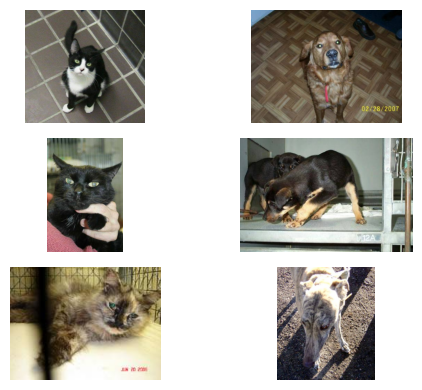

In [3]:
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

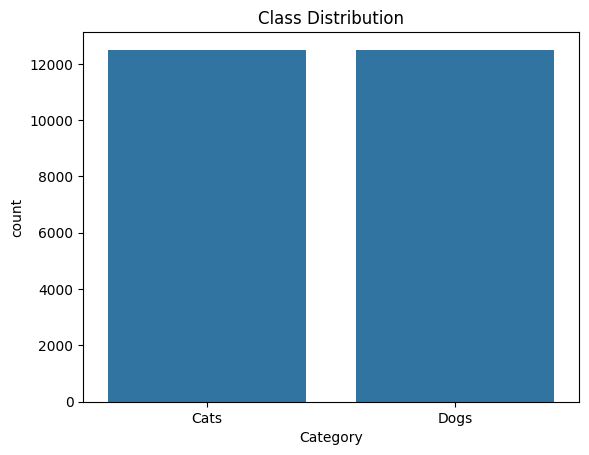

In [4]:
# Load one of the images as an array and look at it's shape - what do you see, what are the dimensions? Are they what you expect?
data = {'Category': ['Cats'] * len(training_cats) + ['Dogs'] * len(training_dogs)}
df = pd.DataFrame(data)

sns.countplot(x='Category', data=df)
plt.title("Class Distribution")
plt.show()

In [5]:
# Plot a histogram of the three 2D arrays which comprise the image. What do you see?

image = Image.open(training_cats[6])
image_array = np.array(image)

# Check the shape
print(f"Image shape: {image_array.shape}")

Image shape: (499, 333, 3)


### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

In [6]:
# Loop over a few hundred images and extract their width and heigh, plot both as a histogram. What do you see, does this information matter to us, if so, how?
dims = []
def get_image_size(image_path):
    img = Image.open(image_path)
    return img.size

for img_path in training_cats:
    size = get_image_size(img_path)
    dims.append({'Category': 'Cat', 'Width': size[0], 'Height': size[1]})

for img_path in training_dogs:
    size = get_image_size(img_path)
    dims.append({'Category': 'Dog', 'Width': size[0], 'Height': size[1]})

df_dims = pd.DataFrame(dims)
print(df_dims.head())


  Category  Width  Height
0      Cat    499     473
1      Cat    333     499
2      Cat    207     156
3      Cat    307     500
4      Cat    500     317


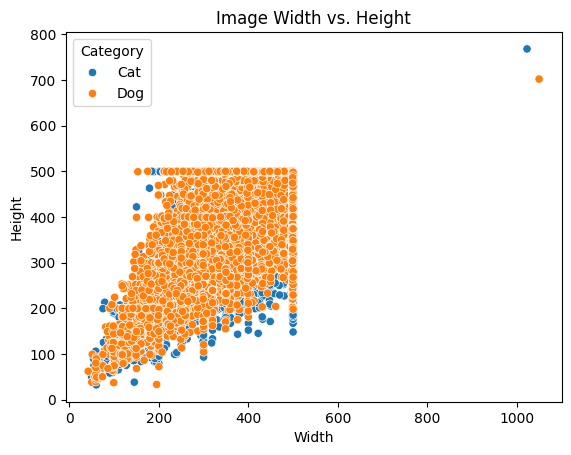

In [7]:
sns.scatterplot(x=df_dims['Width'], y=df_dims['Height'], hue=df_dims['Category'])
plt.title("Image Width vs. Height")
plt.show()

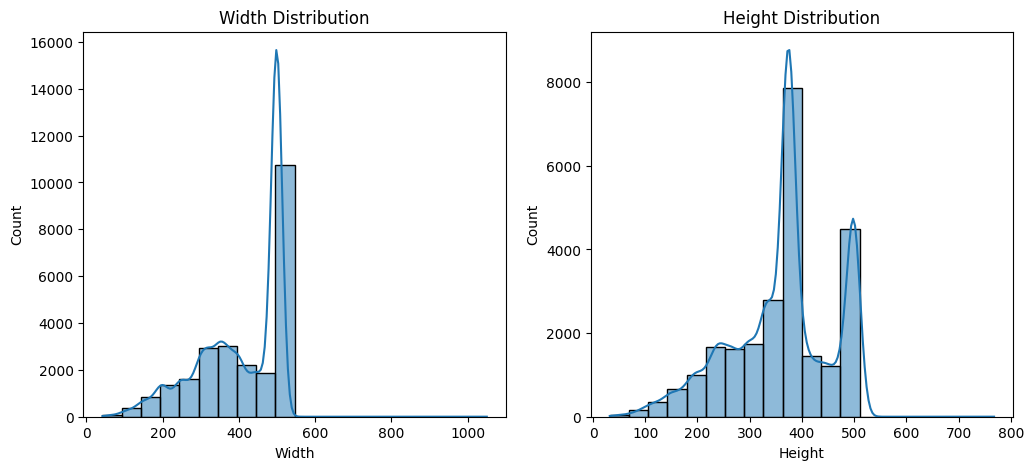

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_dims['Width'], kde=True, bins=20, ax=ax[0])
ax[0].set_title("Width Distribution")

sns.histplot(df_dims['Height'], kde=True, bins=20, ax=ax[1])
ax[1].set_title("Height Distribution")

plt.show()

In [9]:
# Define target size for resizing
TARGET_SIZE = (128, 128)

# Define paths for saving processed images
processed_data_path = "../data/processed/augmented"
os.makedirs(processed_data_path, exist_ok=True)

In [10]:
def process_image(image_path):
    """Loads an image, resizes it, and applies augmentation."""
    img = Image.open(image_path)

    # Resize image
    img = img.resize(TARGET_SIZE, Image.Resampling.LANCZOS)

    # Random horizontal flip
    if random.random() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Random rotation between -25° and 25°
    angle = random.randint(-25, 25)
    img = img.rotate(angle)

    return img

In [11]:
def process_and_save_images(image_paths, category):
    """Processes images and saves them into the augmented dataset."""
    save_dir = os.path.join(processed_data_path, category)
    os.makedirs(save_dir, exist_ok=True)

    for idx, img_path in enumerate(image_paths):
        processed_img = process_image(img_path)

        # Define save path with new filename
        save_path = os.path.join(save_dir, f"{category}_{idx}.jpg")
        processed_img.save(save_path)

# Process both categories
process_and_save_images(training_dogs, "dog")
process_and_save_images(training_cats, "cat")

print("Processing completed! All images saved.")

Processing completed! All images saved.


### 2.3. Image aspect ratios

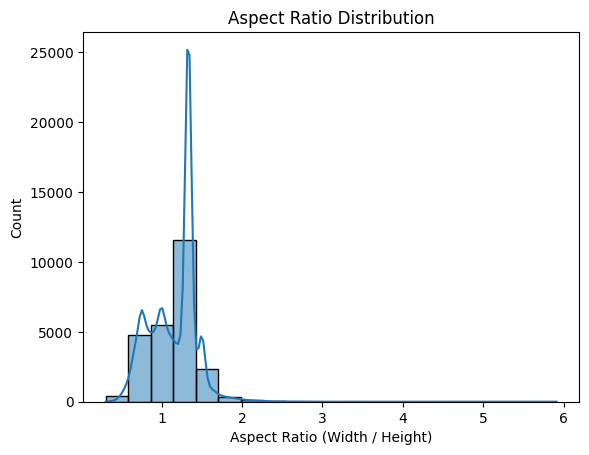

In [12]:
# Plot a histogram of the image aspect ratios (i.e. width/height) What do you see, does this information matter to us, if so, how?
# Compute aspect ratios
df_dims["Aspect_Ratio"] = df_dims["Width"] / df_dims["Height"]

# Visualize aspect ratio distribution
sns.histplot(df_dims["Aspect_Ratio"], kde=True, bins=20)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.show()

## 3. Build the model

### 3.1. Prepare images for streaming

In [13]:
# Define new processed dataset path
processed_data_path = "../data/processed/augmented"

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    processed_data_path, 
    target_size=(128, 128), 
    batch_size=32, 
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    processed_data_path, 
    target_size=(128, 128), 
    batch_size=32, 
    class_mode="binary",
    subset="validation"
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [14]:
# def make_datasets(
#         training_data_path: str,
#         image_width: int,
#         image_height: int, 
#         batch_size: int=32,
#         steps_per_epoch: int=50,
#         epochs: int=10
# ) -> Tuple[tf.data.Dataset, tf.data.Dataset]:

#     training_dataset, validation_dataset=tf.keras.utils.image_dataset_from_directory(
#         training_data_path,
#         validation_split=0.2,
#         subset='both',
#         seed=315,
#         shuffle=True,
#         image_size=(image_width, image_height),
#         batch_size=batch_size
#     )

#     epoch_images=batch_size*steps_per_epoch
#     total_images=epoch_images*epochs

#     training_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()
#     validation_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()

#     return training_dataset, validation_dataset


# training_dataset, validation_dataset=make_datasets(
#     training_data_path,
#     image_width=64,
#     image_height=48,
#     batch_size=64,
#     steps_per_epoch=50,
#     epochs=100
# )

### 3.1. Model definition

In [15]:
# Load pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x =Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification (cats vs. dogs)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers for baseline training
# for layer in base_model.layers:
#     layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# def compile_model(image_width, image_height, learning_rate):

#     initializer=tf.keras.initializers.GlorotUniform(seed=315)

#     model=Sequential([
#         layers.Input((image_width, image_height, 3)),
#         layers.Rescaling(1./255),
#         layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
#         layers.MaxPooling2D(),
#         layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
#         layers.MaxPooling2D(),
#         layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dense(128, activation='relu', kernel_initializer=initializer),
#         layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
#     ])

#     optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

#     return model


# model=compile_model(
#     image_width=64,
#     image_height=48, 
#     learning_rate=0.1
# )

# model.summary()

### 3.2. Model training

In [17]:
# %%time

# training_results=model.fit(
#   training_dataset,
#   validation_data=validation_dataset,
#   epochs=100,
#   steps_per_epoch=50,
#   validation_steps=50,
#   verbose=0
# )

# print()

In [18]:
batch_sizes = [16, 32, 64, 128]
for bs in batch_sizes:
    datagen.batch_size = bs  # Modify batch size dynamically
    history = model.fit(train_generator, epochs=5, verbose=0)
    print(f"Batch Size {bs}: Completed Training")

/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-03 14:53:07.074367: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-04-03 14:53:07.113495: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-04-03 14:53:07.125380: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-04-03 14:53:07.132554: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-04-03 14:5

Batch Size 16: Completed Training
Batch Size 32: Completed Training
Batch Size 64: Completed Training
Batch Size 128: Completed Training


In [19]:
def lr_schedule(epoch, lr):
    return lr * 0.9  # Reduce learning rate gradually

callbacks = [LearningRateScheduler(lr_schedule)]

history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=callbacks)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 538s 861ms/step - accuracy: 0.9892 - loss: 0.0259 - val_accuracy: 0.9424 - val_loss: 0.3451 - learning_rate: 9.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 543s 869ms/step - accuracy: 0.9944 - loss: 0.0168 - val_accuracy: 0.9450 - val_loss: 0.4426 - learning_rate: 8.1000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 544s 870ms/step - accuracy: 0.9954 - loss: 0.0125 - val_accuracy: 0.9482 - val_loss: 0.3568 - learning_rate: 7.2900e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 551s 882ms/step - accuracy: 0.9974 - loss: 0.0079 - val_accuracy: 0.9458 - val_loss: 0.3642 - learning_rate: 6.5610e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 541s 866ms/step - accuracy: 0.9956 - loss: 0.0126 - val_accuracy: 0.9560 - val_loss: 0.2862 - learning_rate: 5.9049e-04
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 551s 881ms/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 0.9560 - val_loss: 0.2628 - learning_rate: 5.3144e-04
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 

In [20]:
# Take a look the information 'training_results' contains. Plot the training 
# and validation accuracy (and binary cross-entropy if you like) over the
# training epochs. Is the model learning? If not, what do you think
# is wrong?
 
# # Set-up a 1x2 figure for accuracy and binary cross-entropy
# fig, axs=plt.subplots(1,2, figsize=(8,4))

# # Add the main title
# fig.suptitle('CNN training curves', size='large')

# # Plot training and validation accuracy
# axs[0].set_title('Accuracy')
# axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
# axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Accuracy (%)')
# axs[0].legend(loc='upper left')

# # Plot training and validation binary cross-entropy
# axs[1].set_title('Binary cross-entropy')
# axs[1].plot(training_results.history['loss'])
# axs[1].plot(training_results.history['val_loss'])
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Binary cross-entropy')

# # Show the plot
# fig.tight_layout()

### 3.3. Model optimization

In [2]:
# Try optimizing the learning rate and the batch size using a few values near the default settings. Hint: use a loop!
def build_model(hp):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(
        units=hp.Int("units", min_value=64, max_value=256, step=64), 
        activation="relu")(x)
    x = Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1))(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(hp.Float("learning_rate", min_value=0.0001, max_value=0.01, sampling="log")),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

tuner = BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="kt_search",
    project_name="cats_dogs_tuning"
)

tuner.search(train_generator, epochs=10, validation_data=val_generator)

NameError: name 'BayesianOptimization' is not defined

In [ ]:
# Pick the best values for learning rate and batch size and train the model for longer

## 4. Evaluate the model

In [ ]:
# Test the model out on the test data - is it as good as you expected, given the training data? Worse? Better? Why?
test_data_path = "../data/processed/test"

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_data_path, target_size=(128, 128), batch_size=32, class_mode="binary", shuffle=False)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

In [ ]:
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)

sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()